In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Ustawienie ziarna losowości dla powtarzalności
np.random.seed(123)

def generate_ar1_errors(n, rho):
    """
    Generuje autokorelowane błędy AR(1): e_t = rho * e_{t-1} + u_t
    Zapewnia var(e_t) = 1 poprzez skalowanie szumu wejściowego.
    """
    if abs(rho) >= 1:
        raise ValueError("Parametr rho musi być < 1 (stacjonarność)")

    # Skalowanie u_t, aby Var(errors) = 1
    sigma_u = np.sqrt(1 - rho**2)

    errors = np.zeros(n)
    # Generujemy u_t o mniejszej wariancji
    u = np.random.randn(n) * sigma_u

    # Warunek początkowy (losowy ze stacjonarnego rozkładu)
    errors[0] = np.random.randn()

    for t in range(1, n):
        errors[t] = rho * errors[t-1] + u[t]
    return errors

def generate_var_data(n, alpha1, alpha2, beta1, beta2, delta1, delta2, rho_eps):
    """
    Generuje dane VAR.
    X_t = alpha1 + beta1*X_{t-1} + delta1*Y_{t-1} + eps_t (eps ~ AR(1))
    Y_t = alpha2 + beta2*X_{t-1} + delta2*Y_{t-1} + eta_t (eta ~ iid)
    """
    # Burn-in (odrzucamy pierwsze 100 obs)
    n_total = n + 1000
    X = np.zeros(n_total)
    Y = np.zeros(n_total)

    # Generuj błędy: eps (autokorelowany), eta (iid)
    eps = generate_ar1_errors(n_total, rho_eps)
    eta = np.random.randn(n_total)

    # Warunki początkowe
    X[0] = np.random.randn()
    Y[0] = np.random.randn()

    for t in range(1, n_total):
        X[t] = alpha1 + beta1 * X[t-1] + delta1 * Y[t-1] + eps[t]
        Y[t] = alpha2 + beta2 * X[t-1] + delta2 * Y[t-1] + eta[t]

    return X[1000:], Y[1000:]


def run_granger_tests(y_target, x_source, alpha=0.05):
    """
    Wykonuje testy i zwraca:
    - rejections: dict with booleans
    - pvalues: dict with p-values
    """
    n = len(y_target)
    if n < 5:
        return None
    lags_hac = int(max(1, n**0.25))
    y_curr = y_target[1:]
    X_mat = np.column_stack([np.ones(n-1), x_source[:-1], y_target[:-1]])
    R = np.array([[0, 1, 0]])
    rejections = {}
    pvals = {}
    try:
        model_std = OLS(y_curr, X_mat).fit()
        p_std = model_std.f_test(R).pvalue.item()
        rejections['standard'] = p_std < alpha
        pvals['standard'] = float(p_std)

        model_nw = OLS(y_curr, X_mat).fit(cov_type='HAC', cov_kwds={'maxlags': lags_hac})
        p_nw = model_nw.f_test(R).pvalue.item()
        rejections['hac_nw'] = p_nw < alpha
        pvals['hac_nw'] = float(p_nw)

        model_bart = OLS(y_curr, X_mat).fit(cov_type='HAC', cov_kwds={'maxlags': lags_hac, 'kernel': 'bartlett'})
        p_bart = model_bart.f_test(R).pvalue.item()
        rejections['hac_bartlett'] = p_bart < alpha
        pvals['hac_bartlett'] = float(p_bart)

    except Exception as e:
        # jeśli błąd numeryczny -> zwróć None
        # print("Błąd w run_granger_tests:", e)
        return None

    return {'rejections': rejections, 'pvalues': pvals}


In [ ]:

# # Parametry badania
N_sim = 1000         # Liczba powtórzeń Monte Carlo
N_obs_list = [100]   # Długości próbki
rho_list = [-0.5, 0.0, 0.3, 0.5, 0.7] # Siła autokorelacji błędów (0 = benchmark)

params_fixed = {
    'alpha1': 1, 'alpha2': 1,
    'beta1': 0.2,  # Autokorelacja własna X
    'delta1': 0,   # H0 PRAWDZIWA (brak przyczynowości Y->X)
    'beta2': 0,    # Brak X->Y (upraszcza układ)
    'delta2': -0.2  # Autokorelacja własna Y
}

results_data = []

print(f"Rozpoczynanie symulacji (MC={N_sim})...")


for N in N_obs_list:
    for rho in rho_list:
        counts = {'standard': 0, 'hac_nw': 0, 'hac_bartlett': 0}
        valid_iters = 0
        for _ in range(N_sim):
            X, Y = generate_var_data(n=N, rho_eps=rho, **params_fixed)
            res = run_granger_tests(y_target=X, x_source=Y)
            if res is not None:
                valid_iters += 1
                for k in counts:
                    if res['rejections'][k]:
                        counts[k] += 1
        if valid_iters == 0:
            continue
        row = {
            'N': N,
            'rho_eps': rho,
            'beta1': params_fixed['beta1'],
            'delta2': params_fixed['delta2'],
            'n_valid': valid_iters,
            'standard': counts['standard'] / valid_iters,
            'hac_nw': counts['hac_nw'] / valid_iters,
            'hac_bartlett': counts['hac_bartlett'] / valid_iters
        }
        results_data.append(row)

# Tworzenie DataFrame
df_results = pd.DataFrame(results_data)

# --- ANALIZA STATYSTYCZNA I PREZENTACJA ---

print("\n" + "="*80)
print(f"WYNIKI SYMULACJI (Poziom istotności nominalny: 0.05)")
print("Przedziały ufności 95% (Rozkład Normalny aproksymujący Bernoulliego)")
print("="*80)

# Formatowanie wyjścia
print(f"{'N':<5} {'rho':<5} | {'TEST':<12} | {'SIZE':<8} | {'95% CI':<20} | {'Ocena'}")
print("-" * 80)

for _, row in df_results.iterrows():
    n_rep = row['n_valid']

    for test in ['standard', 'hac_nw', 'hac_bartlett']:
        p_hat = row[test]

        # Błąd standardowy frakcji (SE)
        se = np.sqrt(p_hat * (1 - p_hat) / n_rep)

        # Przedział ufności [p - 1.96*SE, p + 1.96*SE]
        ci_low = max(0.0, p_hat - 1.96 * se)
        ci_high = min(1.0, p_hat + 1.96 * se)

        # Ocena słowna
        status = ""
        if ci_low <= 0.05 <= ci_high:
            status = "OK"
        elif p_hat > 0.05:
            status = "NADWYMIAROWY"
        else:
            status = "KONSERWATYWNY"

        # Wypisanie tylko dla pierwszej iteracji wiersza parametrów
        if test == 'standard':
             print(f"{int(row['N']):<5} {row['rho_eps']:<5} | {test:<12} | {p_hat:<8.3f} | [{ci_low:.3f}, {ci_high:.3f}]      | {status}")
        else:
             print(f"{'':<5} {'':<5} | {test:<12} | {p_hat:<8.3f} | [{ci_low:.3f}, {ci_high:.3f}]      | {status}")
    print("-" * 80)

Rozpoczynanie symulacji (MC=1000)...

WYNIKI SYMULACJI (Poziom istotności nominalny: 0.05)
Przedziały ufności 95% (Rozkład Normalny aproksymujący Bernoulliego)
N     rho   | TEST         | SIZE     | 95% CI               | Ocena
--------------------------------------------------------------------------------
100   -0.5  | standard     | 0.052    | [0.038, 0.066]      | OK
            | hac_nw       | 0.081    | [0.064, 0.098]      | NADWYMIAROWY
            | hac_bartlett | 0.081    | [0.064, 0.098]      | NADWYMIAROWY
--------------------------------------------------------------------------------
100   0.0   | standard     | 0.055    | [0.041, 0.069]      | OK
            | hac_nw       | 0.071    | [0.055, 0.087]      | NADWYMIAROWY
            | hac_bartlett | 0.071    | [0.055, 0.087]      | NADWYMIAROWY
--------------------------------------------------------------------------------
100   0.3   | standard     | 0.047    | [0.034, 0.060]      | OK
            | hac_nw       | 0.06

In [ ]:
df_results

,N,rho_eps,beta1,delta2,n_valid,standard,hac_nw,hac_bartlett
0,100,-0.5,0.2,-0.2,1000,0.052,0.081,0.081
1,100,0.0,0.2,-0.2,1000,0.055,0.071,0.071
2,100,0.3,0.2,-0.2,1000,0.047,0.065,0.065
3,100,0.5,0.2,-0.2,1000,0.046,0.069,0.069
4,100,0.7,0.2,-0.2,1000,0.040,0.064,0.064


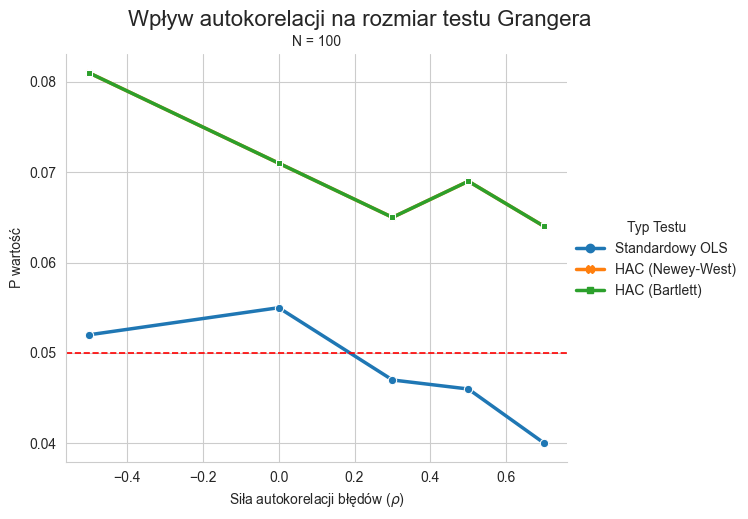

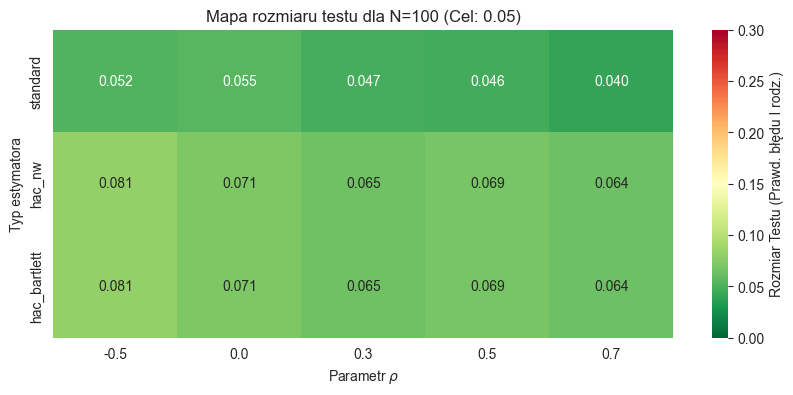

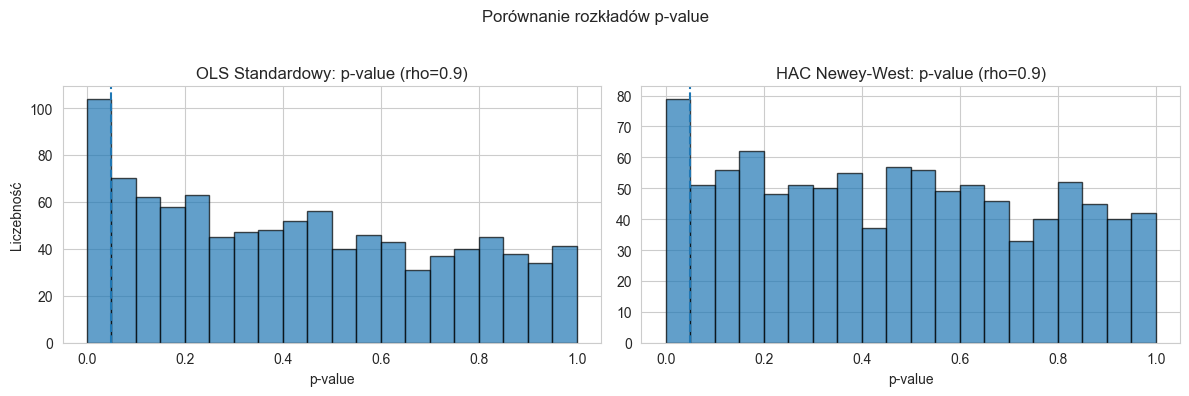

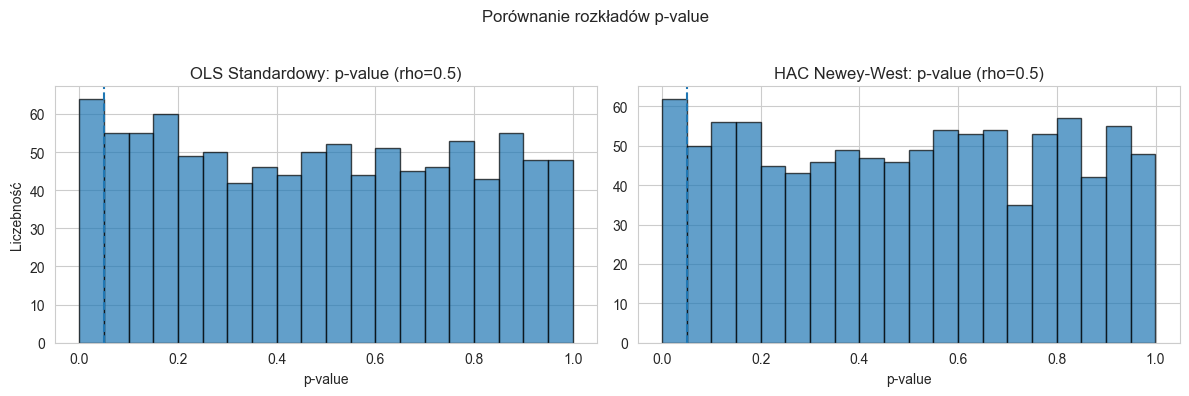

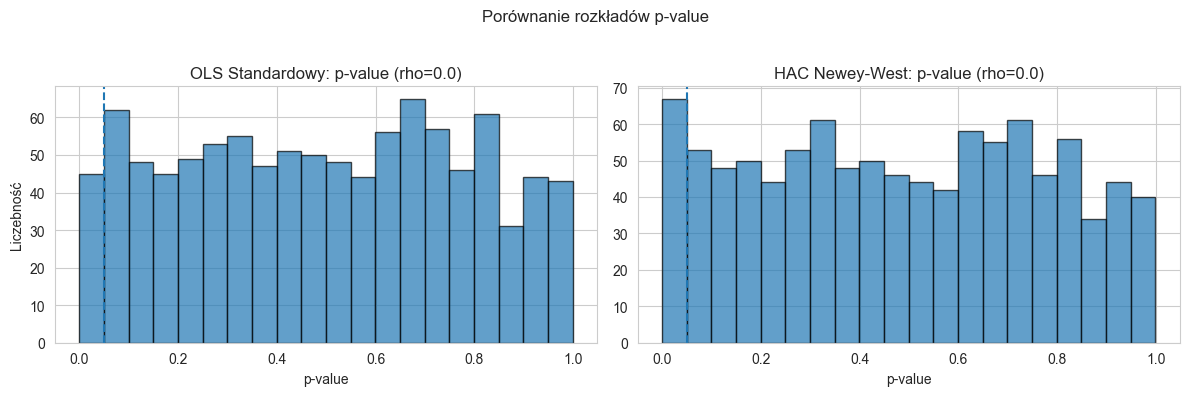

In [ ]:

# --- WIZUALIZACJA ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def visualize_results(df):
    # melt
    df_melt = df.melt(
        id_vars=['N', 'rho_eps'],
        value_vars=['standard', 'hac_nw', 'hac_bartlett'],
        var_name='Typ Testu',
        value_name='P wartość'
    )
    names_map = {
        'standard': 'Standardowy OLS',
        'hac_nw': 'HAC (Newey-West)',
        'hac_bartlett': 'HAC (Bartlett)'
    }
    df_melt['Typ Testu'] = df_melt['Typ Testu'].map(names_map)

    # Wykres liniowy (size vs rho) - jeden panel na każdy N
    unique_N = sorted(df['N'].unique())
    g = sns.relplot(
        data=df_melt,
        x='rho_eps', y='P wartość',
        hue='Typ Testu', col='N', kind='line',
        style='Typ Testu', markers=True, dashes=False,
        height=5, aspect=1.2, linewidth=2.5
    )
    for ax in g.axes.flat:
        ax.axhline(0.05, color='red', linestyle='--', linewidth=1.2)
        # poprawny tytuł
        title = ax.get_title()
        # jeśli tytuł zawiera "N = 100" to zostaw
        ax.set_xlabel(r"Siła autokorelacji błędów ($\rho$)")
    g.fig.suptitle("Wpływ autokorelacji na rozmiar testu Grangera", y=1.02, fontsize=16)
    plt.show()

    # Heatmapa dla pierwszego dostępnego N
    subset_N = unique_N[0]
    df_subset = df[df['N'] == subset_N].set_index('rho_eps')[['standard', 'hac_nw', 'hac_bartlett']]
    plt.figure(figsize=(10, 4))
    sns.heatmap(df_subset.T, annot=True, cmap='RdYlGn_r', fmt=".3f", vmin=0, vmax=0.3,
                cbar_kws={'label': 'Rozmiar Testu (Prawd. błędu I rodz.)'})
    plt.title(f"Mapa rozmiaru testu dla N={subset_N} (Cel: 0.05)")
    plt.xlabel(r"Parametr $\rho$")
    plt.ylabel("Typ estymatora")
    plt.show()

    rho_plot = 0.9
    n_rep = 1000
    p_vals_std = []
    p_vals_nw = []
    for _ in range(n_rep):
        X, Y = generate_var_data(n=200, rho_eps=rho_plot, alpha1=0, alpha2=0, beta1=0.5, beta2=0, delta1=0, delta2=0.5)
        out = run_granger_tests(y_target=X, x_source=Y)
        if out is not None:
            p_vals_std.append(out['pvalues']['standard'])
            p_vals_nw.append(out['pvalues']['hac_nw'])

    # Rysowanie histogramów (dwa wykresy obok siebie)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(p_vals_std, bins=20, alpha=0.7, edgecolor='black')
    axes[0].axvline(0.05, linestyle='--')
    axes[0].set_title(f"OLS Standardowy: p-value (rho={rho_plot})")
    axes[0].set_xlabel("p-value")
    axes[0].set_ylabel("Liczebność")

    axes[1].hist(p_vals_nw, bins=20, alpha=0.7, edgecolor='black')
    axes[1].axvline(0.05, linestyle='--')
    axes[1].set_title(f"HAC Newey-West: p-value (rho={rho_plot})")
    axes[1].set_xlabel("p-value")
    plt.suptitle("Porównanie rozkładów p-value")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    rho_plot = 0.5
    n_rep = 1000
    p_vals_std = []
    p_vals_nw = []
    for _ in range(n_rep):
        X, Y = generate_var_data(n=200, rho_eps=rho_plot, alpha1=0, alpha2=0, beta1=0.5, beta2=0, delta1=0, delta2=0.5)
        out = run_granger_tests(y_target=X, x_source=Y)
        if out is not None:
            p_vals_std.append(out['pvalues']['standard'])
            p_vals_nw.append(out['pvalues']['hac_nw'])

    # Rysowanie histogramów (dwa wykresy obok siebie)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(p_vals_std, bins=20, alpha=0.7, edgecolor='black')
    axes[0].axvline(0.05, linestyle='--')
    axes[0].set_title(f"OLS Standardowy: p-value (rho={rho_plot})")
    axes[0].set_xlabel("p-value")
    axes[0].set_ylabel("Liczebność")

    axes[1].hist(p_vals_nw, bins=20, alpha=0.7, edgecolor='black')
    axes[1].axvline(0.05, linestyle='--')
    axes[1].set_title(f"HAC Newey-West: p-value (rho={rho_plot})")
    axes[1].set_xlabel("p-value")
    plt.suptitle("Porównanie rozkładów p-value")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    rho_plot = 0.0
    n_rep = 1000
    p_vals_std = []
    p_vals_nw = []
    for _ in range(n_rep):
        X, Y = generate_var_data(n=200, rho_eps=rho_plot, alpha1=0, alpha2=0, beta1=0.5, beta2=0, delta1=0, delta2=0.5)
        out = run_granger_tests(y_target=X, x_source=Y)
        if out is not None:
            p_vals_std.append(out['pvalues']['standard'])
            p_vals_nw.append(out['pvalues']['hac_nw'])

    # Rysowanie histogramów (dwa wykresy obok siebie)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(p_vals_std, bins=20, alpha=0.7, edgecolor='black')
    axes[0].axvline(0.05, linestyle='--')
    axes[0].set_title(f"OLS Standardowy: p-value (rho={rho_plot})")
    axes[0].set_xlabel("p-value")
    axes[0].set_ylabel("Liczebność")

    axes[1].hist(p_vals_nw, bins=20, alpha=0.7, edgecolor='black')
    axes[1].axvline(0.05, linestyle='--')
    axes[1].set_title(f"HAC Newey-West: p-value (rho={rho_plot})")
    axes[1].set_xlabel("p-value")
    plt.suptitle("Porównanie rozkładów p-value")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Wywołanie
visualize_results(df_results)


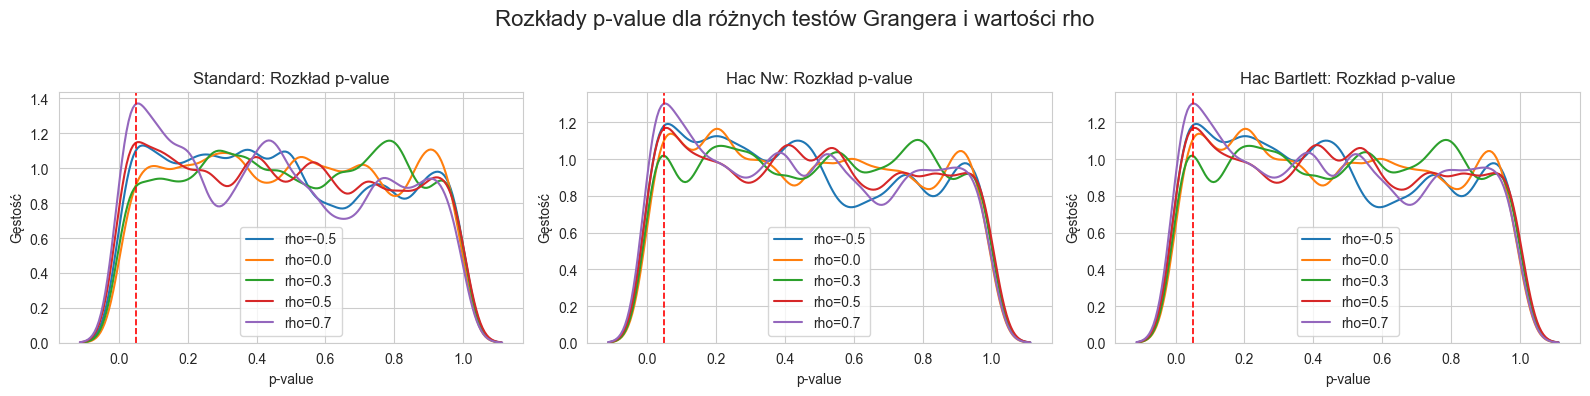

In [ ]:
# --- Parametry ---
rho_list = [-0.5, 0.0, 0.3, 0.5, 0.7]
n_rep = 1000
n_obs = 100

# Funkcje z wcześniejszego kodu (skopiuj generate_var_data i run_granger_tests)

# Przechowujemy p-values
pvals_all = {
    'standard': {rho: [] for rho in rho_list},
    'hac_nw': {rho: [] for rho in rho_list},
    'hac_bartlett': {rho: [] for rho in rho_list}
}

# --- Symulacja ---
for rho in rho_list:
    for _ in range(n_rep):
        X, Y = generate_var_data(
            n=n_obs, rho_eps=rho,
            alpha1=0, alpha2=0, beta1=0.5, beta2=0,
            delta1=0, delta2=0.5
        )
        res = run_granger_tests(y_target=X, x_source=Y)
        if res is not None:
            for test in pvals_all:
                pvals_all[test][rho].append(res['pvalues'][test])

# --- Rysowanie wykresów ---
sns.set_style("whitegrid")
plt.figure(figsize=(16, 4))

for i, test in enumerate(['standard', 'hac_nw', 'hac_bartlett']):
    plt.subplot(1, 3, i+1)
    for rho in rho_list:
        data = pvals_all[test][rho]
        sns.kdeplot(data, label=f"rho={rho}", bw_adjust=0.5)
    plt.axvline(0.05, color='red', linestyle='--', linewidth=1.2)
    plt.title(f"{test.replace('_', ' ').title()}: Rozkład p-value")
    plt.xlabel("p-value")
    plt.ylabel("Gęstość")
    plt.legend()
plt.suptitle("Rozkłady p-value dla różnych testów Grangera i wartości rho", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()